# Case Study 2: Supervised Classification
Group Members: Benjamin Ang, Harvey Felipe, Enika Maninang, Jeremy Tan

## Setup the Raw DataFrame

In [43]:
import pandas as pd

file_name = "AirQualityUCI.csv"

# Read the Excel file into a DataFrame
df = pd.read_table(file_name, sep = ';')


# type(df.iloc[0,2])
df['CO(GT)'] = df['CO(GT)'].astype(str).map(lambda a: float(a.replace(",",".")))
df['C6H6(GT)'] = df['C6H6(GT)'].astype(str).map(lambda a: float(a.replace(",",".")))

# df.reset_index(drop=True, inplace=True)

df = df.iloc[:,:-2] # drop the last two columns
df = df.dropna(how = "any")

# Z score normalization
# normalize the four variables of interest: CO(GT), NMHC(GT), C6H6(GT), NOx(GT)

df['CO(GT)'] = (df['CO(GT)']-df['CO(GT)'].mean())/df['CO(GT)'].std()
df['NMHC(GT)'] = (df['NMHC(GT)']-df['NMHC(GT)'].mean())/df['NMHC(GT)'].std()
df['C6H6(GT)'] = (df['C6H6(GT)']-df['C6H6(GT)'].mean())/df['C6H6(GT)'].std()
df['NOx(GT)'] = (df['NOx(GT)']-df['NOx(GT)'].mean())/df['NOx(GT)'].std()

# Display the first few rows of the DataFrame to verify
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,0.473975,1360.0,2.211117,0.242491,1046.0,-0.010166,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,0.466248,1292.0,1.939279,0.182075,955.0,-0.254889,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,0.468824,1402.0,1.767592,0.172409,939.0,-0.146123,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,0.468824,1376.0,1.710363,0.177242,948.0,0.013141,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,0.461097,1272.0,1.502908,0.111994,836.0,-0.146123,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


We decided to perform normalization in this dataset because the original values had a very wide range of values and the scale of the column values differed greatly. One of the regression models used was Support Vector Regression which necessitates that the features have similar scales.

## Setup a Given Field for X and Y

In [44]:
import pandas as pd
import numpy as np

def create_time_series_dataset(df, column_name, window_size):
    """
    Create a dataset with overlapping windows for time series prediction.

    Parameters:
    - df: pandas DataFrame containing the time series data.
    - column_name: string, the name of the column with the time series data.
    - window_size: int, the size of the window to use for each sample.

    Returns:
    - X: pandas DataFrame with the past observations.
    - y: pandas Series with the next value to predict.
    """
    # Extract the relevant column
    series = df[column_name].values

    # Initialize lists to hold the data
    X = []
    y = []

    # Create windows
    for i in range(len(series) - window_size):
        window = series[i:i + window_size]
        next_value = series[i + window_size]
        X.append(window)
        y.append(next_value)

    # Convert lists to DataFrame/Series
    X = pd.DataFrame(X, columns=[f"x{i+1}" for i in range(window_size)])
    y = pd.Series(y, name='y')

    return X, y

# Example usage:
# Assuming 'df' is your DataFrame and 'DAX' is the column you want to use
window_size = 10  # For example, use the past 10 observations

co_X, co_y = create_time_series_dataset(df, 'CO(GT)', window_size)
nmch_X, nmch_y = create_time_series_dataset(df, 'NMHC(GT)', window_size)
c6h6_X, c6h6_y = create_time_series_dataset(df, 'C6H6(GT)', window_size)
nox_X, nox_y = create_time_series_dataset(df, 'NOx(GT)', window_size)


## Use a Classification Model (Random Forest Regressor)

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Split the data chronologically
split_index = int(len(co_X) * 0.8)  # 80% training, 20% testing
co_X_train, co_X_test = co_X.iloc[:split_index], co_X.iloc[split_index:]
co_y_train, co_y_test = co_y.iloc[:split_index], co_y.iloc[split_index:]

nmch_X_train, nmch_X_test = nmch_X.iloc[:split_index], nmch_X.iloc[split_index:]
nmch_y_train, nmch_y_test = nmch_y.iloc[:split_index], nmch_y.iloc[split_index:]

c6h6_X_train, c6h6_X_test = c6h6_X.iloc[:split_index], c6h6_X.iloc[split_index:]
c6h6_y_train, c6h6_y_test = c6h6_y.iloc[:split_index], c6h6_y.iloc[split_index:]

nox_X_train, nox_X_test = nox_X.iloc[:split_index], nox_X.iloc[split_index:]
nox_y_train, nox_y_test = nox_y.iloc[:split_index], nox_y.iloc[split_index:]


# Initialize and train the Random Forest model
co_rf_model = RandomForestRegressor(random_state=42)
nmch_rf_model = RandomForestRegressor(random_state=42)
c6h6_rf_model = RandomForestRegressor(random_state=42)
nox_rf_model = RandomForestRegressor(random_state=42)

co_rf_model.fit(co_X_train, co_y_train)
nmch_rf_model.fit(nmch_X_train, nmch_y_train)
c6h6_rf_model.fit(c6h6_X_train, c6h6_y_train)
nox_rf_model.fit(nox_X_train, nox_y_train)

# Predict on the test set
co_y_pred = co_rf_model.predict(co_X_test)
nmch_y_pred = nmch_rf_model.predict(nmch_X_test)
c6h6_y_pred = c6h6_rf_model.predict(c6h6_X_test)
nox_y_pred = nox_rf_model.predict(nox_X_test)

# Measure performance
co_mse = mean_squared_error(co_y_test, co_y_pred)
nmch_mse = mean_squared_error(nmch_y_test, nmch_y_pred)
c6h6_mse = mean_squared_error(c6h6_y_test, c6h6_y_pred)
nox_mse = mean_squared_error(nox_y_test, nox_y_pred)

print(f"Mean Squared Error of CO(GT): {co_mse:.8f}")
print(f"Mean Squared Error of NMCH(GT): {nmch_mse:.8f}")
print(f"Mean Squared Error of C6H6(GT): {c6h6_mse:.8f}")
print(f"Mean Squared Error of NOx(GT): {nox_mse:.8f}")

# Optionally, display the first few actual vs. predicted values
co_comparison = pd.DataFrame({'Actual':co_y_test, 'Predicted': co_y_pred})
nmch_comparison = pd.DataFrame({'Actual':nmch_y_test, 'Predicted': nmch_y_pred})
c6h6_comparison = pd.DataFrame({'Actual':c6h6_y_test, 'Predicted': c6h6_y_pred})
nox_comparison = pd.DataFrame({'Actual': nox_y_test, 'Predicted': nox_y_pred})

print(co_comparison.head())
print(nmch_comparison.head())
print(c6h6_comparison.head())
print(nox_comparison.head())

Mean Squared Error of CO(GT): 0.17437531
Mean Squared Error of NMCH(GT): 0.00000585
Mean Squared Error of C6H6(GT): 0.09500318
Mean Squared Error of NOx(GT): 0.21501525
        Actual  Predicted
7477  0.454659   0.461741
7478  0.455947   0.459205
7479  0.466248   0.456732
7480  0.468824   0.468643
7481  0.459810   0.469081
        Actual  Predicted
7477 -0.292654  -0.290235
7478 -0.292654  -0.290235
7479 -0.292654  -0.290235
7480 -0.292654  -0.290235
7481 -0.292654  -0.290235
        Actual  Predicted
7477  0.034662  -0.184670
7478  0.037079   0.069461
7479  0.126493   0.064870
7480  0.133743   0.166222
7481  0.058828   0.121443
        Actual  Predicted
7477  0.044217   0.059716
7478  0.168521   0.067019
7479  0.630776   0.166812
7480  0.778386   0.492294
7481  0.409360   0.708699


### Compare against another Regression Model (SVM)

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the SVR model with the default Radial Basis Function kernel
co_svr_model = SVR(kernel='rbf')
nmch_svr_model = SVR(kernel = 'rbf')
c6h6_svr_model = SVR(kernel = 'rbf')
nox_svr_model = SVR(kernel = 'rbf')

co_svr_model.fit(co_X_train, co_y_train)
nmch_svr_model.fit(nmch_X_train, nmch_y_train)
c6h6_svr_model.fit(c6h6_X_train, c6h6_y_train)
nox_svr_model.fit(nox_X_train, nox_y_train)

# Predict on the test set
co_y_pred = co_svr_model.predict(co_X_test)
nmch_y_pred = nmch_svr_model.predict(nmch_X_test)
c6h6_y_pred = c6h6_svr_model.predict(c6h6_X_test)
nox_y_pred = nox_svr_model.predict(nox_X_test)

# Measure performance
co_mse = mean_squared_error(co_y_test, co_y_pred)
nmch_mse = mean_squared_error(nmch_y_test, nmch_y_pred)
c6h6_mse = mean_squared_error(c6h6_y_test, c6h6_y_pred)
nox_mse = mean_squared_error(nox_y_test, nox_y_pred)

print(f"Mean Squared Error of CO(GT): {co_mse:.8f}")
print(f"Mean Squared Error of NMHC(GT): {nmch_mse:.8f}")
print(f"Mean Squared Error of C6H6(GT): {c6h6_mse:.8f}")
print(f"Mean Squared Error of NOx(GT): {nox_mse:.8f}")

# Optionally, display the first few actual vs. predicted values
co_comparison = pd.DataFrame({'Actual':co_y_test, 'Predicted': co_y_pred})
nmch_comparison = pd.DataFrame({'Actual':nmch_y_test, 'Predicted': nmch_y_pred})
c6h6_comparison = pd.DataFrame({'Actual':c6h6_y_test, 'Predicted': c6h6_y_pred})
nox_comparison = pd.DataFrame({'Actual': nox_y_test, 'Predicted': nox_y_pred})

print(co_comparison.head())
print(nmch_comparison.head())
print(c6h6_comparison.head())
print(nox_comparison.head())


Mean Squared Error of CO(GT): 0.18143859
Mean Squared Error of NMHC(GT): 0.00997496
Mean Squared Error of C6H6(GT): 0.08694214
Mean Squared Error of NOx(GT): 0.20808837
        Actual  Predicted
7477  0.454659   0.390871
7478  0.455947   0.392246
7479  0.466248   0.393927
7480  0.468824   0.399641
7481  0.459810   0.403058
        Actual  Predicted
7477 -0.292654   -0.19278
7478 -0.292654   -0.19278
7479 -0.292654   -0.19278
7480 -0.292654   -0.19278
7481 -0.292654   -0.19278
        Actual  Predicted
7477  0.034662   0.107444
7478  0.037079   0.117110
7479  0.126493   0.113919
7480  0.133743   0.203088
7481  0.058828   0.173932
        Actual  Predicted
7477  0.044217   0.066882
7478  0.168521   0.066768
7479  0.630776   0.140799
7480  0.778386   0.595473
7481  0.409360   0.606080


Both the SVM and Random Forest Regressor models have similar performance in terms of MSE.

In [ ]:
# Different window sizes for CO

co_X_2, co_y_2 = create_time_series_dataset(df, 'CO(GT)', 2)
co_X_5, co_y_5 = create_time_series_dataset(df, 'CO(GT)', 5)
co_X_20, co_y_20 = create_time_series_dataset(df, 'CO(GT)', 20)
co_X_50, co_y_50 = create_time_series_dataset(df, 'CO(GT)', 50)

co_X_2_train, co_X_2_test = co_X_2.iloc[:split_index], co_X_2.iloc[split_index:]
co_X_5_train, co_X_5_test = co_X_5.iloc[:split_index], co_X_5.iloc[split_index:]
co_X_20_train, co_X_20_test = co_X_20.iloc[:split_index], co_X_20.iloc[split_index:]
co_X_50_train, co_X_50_test = co_X_50.iloc[:split_index], co_X_50.iloc[split_index:]

co_y_2_train, co_y_2_test = co_y_2.iloc[:split_index], co_y_2.iloc[split_index:]
co_y_5_train, co_y_5_test = co_y_5.iloc[:split_index], co_y_5.iloc[split_index:]
co_y_20_train, co_y_20_test = co_y_20.iloc[:split_index], co_y_20.iloc[split_index:]
co_y_50_train, co_y_50_test = co_y_50.iloc[:split_index], co_y_50.iloc[split_index:]

co_2_rf_model = RandomForestRegressor(random_state=42)
co_5_rf_model = RandomForestRegressor(random_state=42)
co_20_rf_model = RandomForestRegressor(random_state=42)
co_50_rf_model = RandomForestRegressor(random_state=42)

co_2_rf_model.fit(co_X_2_train, co_y_2_train)
co_5_rf_model.fit(co_X_5_train, co_y_5_train)
co_20_rf_model.fit(co_X_20_train, co_y_20_train)
co_50_rf_model.fit(co_X_50_train, co_y_50_train)

co_y_2_pred = co_2_rf_model.predict(co_X_2_test)
co_y_5_pred = co_5_rf_model.predict(co_X_5_test)
co_y_20_pred = co_20_rf_model.predict(co_X_20_test)
co_y_50_pred = co_50_rf_model.predict(co_X_50_test)

co_2_mse = mean_squared_error(co_y_2_test, co_y_2_pred)
co_5_mse = mean_squared_error(co_y_5_test, co_y_5_pred)
co_20_mse = mean_squared_error(co_y_20_test, co_y_20_pred)
co_50_mse = mean_squared_error(co_y_50_test, co_y_50_pred)

print(f"Mean Squared Error: {co_mse:.4f}")
print(f"Mean Squared Error: {co_2_mse:.4f}")
print(f"Mean Squared Error: {co_5_mse:.4f}")
print(f"Mean Squared Error: {co_20_mse:.4f}")
print(f"Mean Squared Error: {co_50_mse:.4f}")

Mean Squared Error: 0.1744
Mean Squared Error: 0.1953
Mean Squared Error: 0.1922
Mean Squared Error: 0.1718
Mean Squared Error: 0.1701


In [19]:
# Test window sizes from 1 to 50 and select the one with the lowest MSE

def get_mse(col_name):
  MSE = {}

  for window_size in range(1,51):
    X, y = create_time_series_dataset(df, col_name, window_size)

    split_index = int(len(X) * 0.8)  # 80% training, 20% testing
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    # Initialize and train the Random Forest model
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf_model.predict(X_test)

    # Measure performance
    mse = mean_squared_error(y_test, y_pred)
    # print(f"Mean Squared Error: {mse:.4f}")
    MSE[window_size] = mse

  return MSE

co_mse = get_mse('CO(GT)')
nmhc_mse = get_mse('NMHC(GT)')
c6h6_mse = get_mse('C6H6(GT)')
nox_mse = get_mse('NOx(GT)')

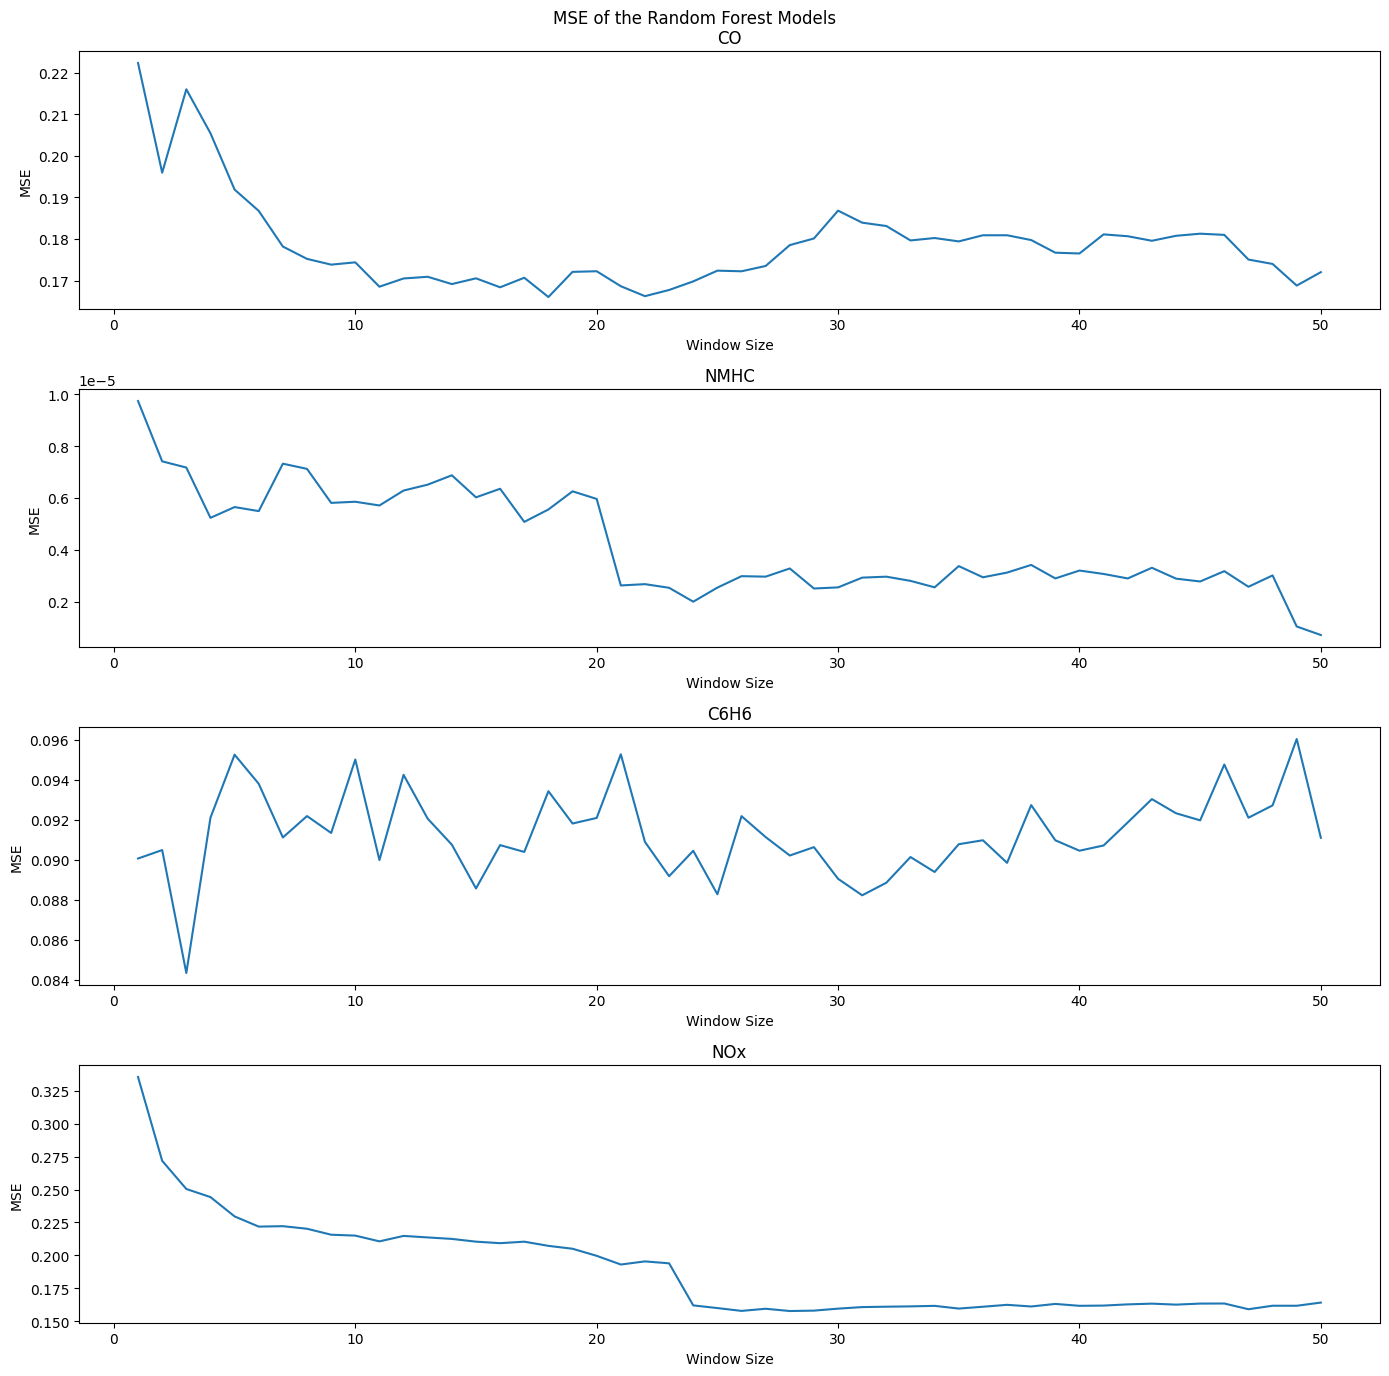

In [39]:
import matplotlib.pyplot as plt

x = np.arange(1,51,1)
co = list(co_mse.values())
nmhc = list(nmhc_mse.values())
c6h6 = list(c6h6_mse.values())
nox = list(nox_mse.values())

# Create the line graph
fig, axs = plt.subplots(4, figsize = (14,14))

axs[0].plot(x, co)
axs[1].plot(x, nmhc)
axs[2].plot(x, c6h6)
axs[3].plot(x, nox)

# Add labels and title
for ax in axs.flat:
    ax.set(xlabel='Window Size', ylabel='MSE')

axs[0].set_title('CO')
axs[1].set_title('NMHC')
axs[2].set_title('C6H6')
axs[3].set_title('NOx')

plt.setp(axs, ylim=(0,0.4))

fig.suptitle('MSE of the Random Forest Models')
plt.tight_layout()

# Show the plot
plt.show()

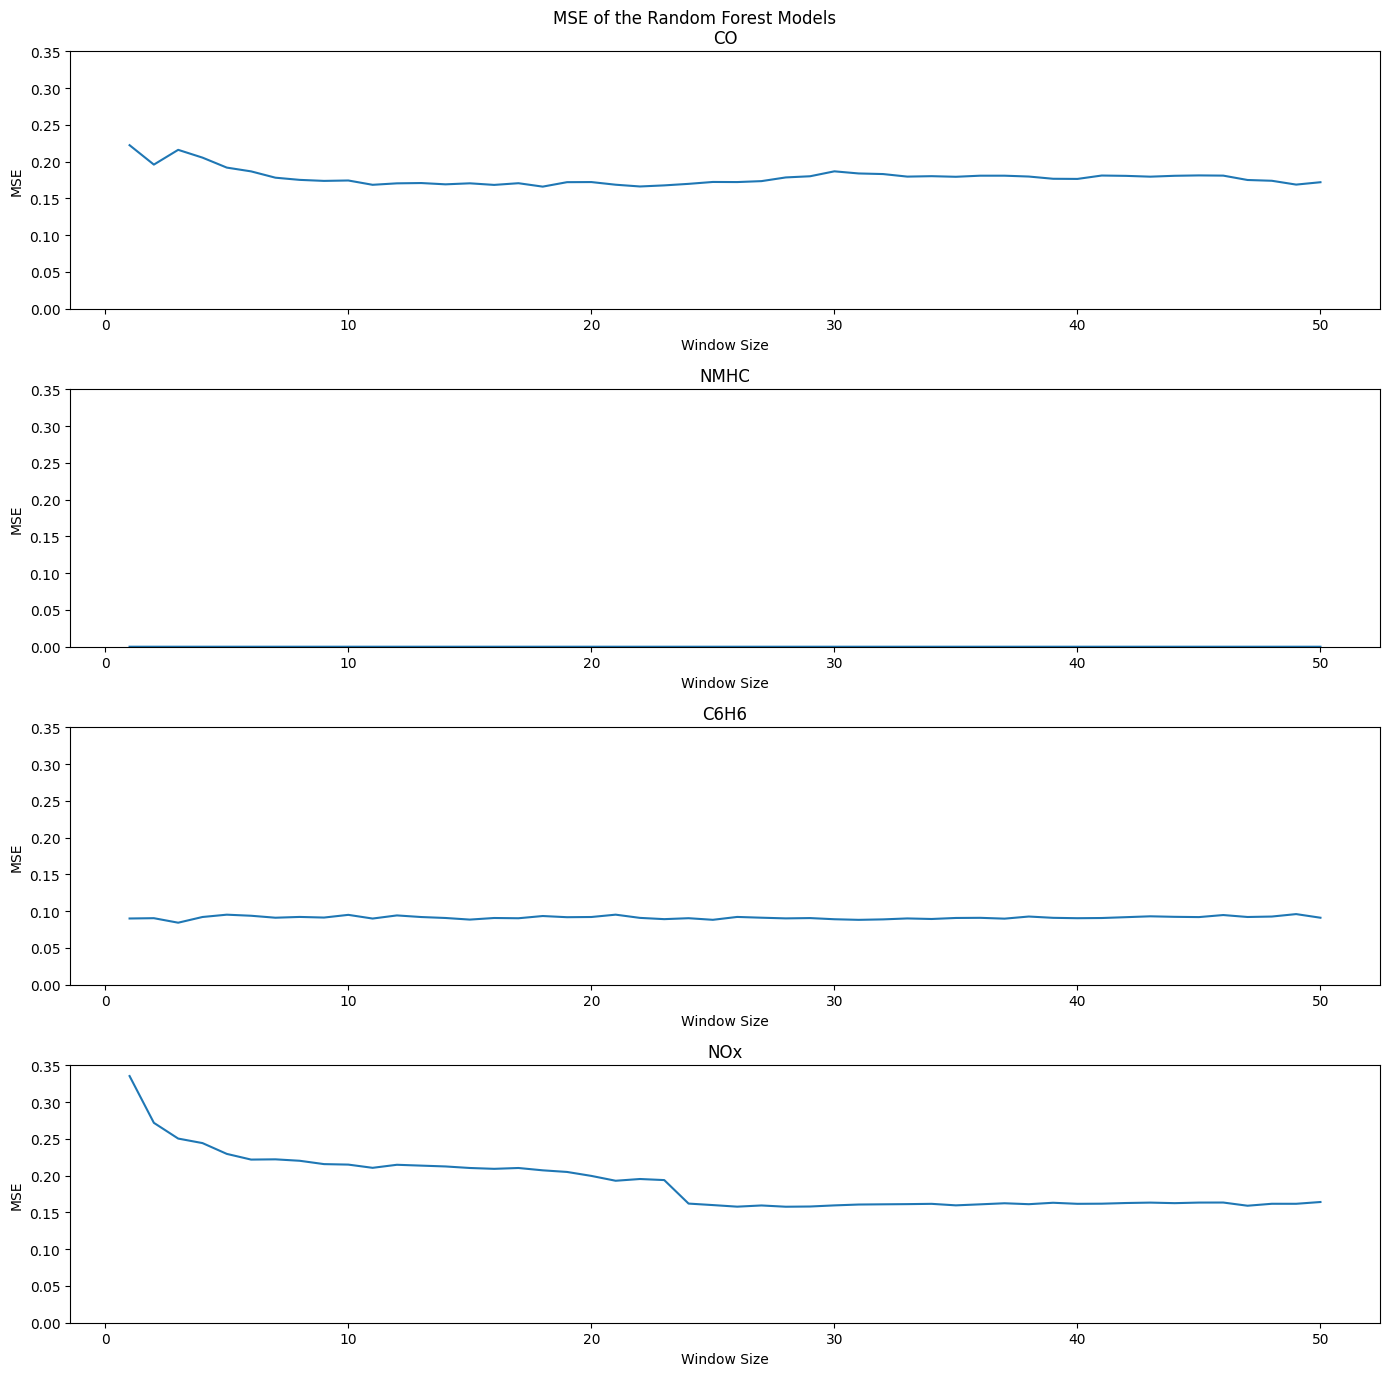

In [42]:
x = np.arange(1,51,1)
co = list(co_mse.values())
nmhc = list(nmhc_mse.values())
c6h6 = list(c6h6_mse.values())
nox = list(nox_mse.values())

# Create the line graph
fig, axs = plt.subplots(4, figsize = (14,14))

axs[0].plot(x, co)
axs[1].plot(x, nmhc)
axs[2].plot(x, c6h6)
axs[3].plot(x, nox)

# Add labels and title
for ax in axs.flat:
    ax.set(xlabel='Window Size', ylabel='MSE')

axs[0].set_title('CO')
axs[1].set_title('NMHC')
axs[2].set_title('C6H6')
axs[3].set_title('NOx')

plt.setp(axs, ylim=(0,0.35))

fig.suptitle('MSE of the Random Forest Models')
plt.tight_layout()

# Show the plot
plt.show()

<b>Guide Question 1</b>. Does changing the window size x affect the performance? Try out different sizes and see for yourself. Why is this the case based on how long or how short the window size is?

Generally, we can see that increasing the window size improves model performance. In the CO model, from window sizes 1 to 10, there was a large decrease in the MSE of the Random Forest model, which then climbs up again from window sizes 10-30, before continuing to go down again until window size 50. On the other hand, for the NMHC and NOx models, there is a clear downward trend as the window size increases. Though the C6H6 model presents an exception showing no clear pattern in model improvement. However, a bigger picture view of the plots of the MSE values show that the model has exhibited a constantly near-to-zero MSE value through all of the window sizes, which shows that it still agrees with the finding that larger window sizes increase performance.

## Plot it Out

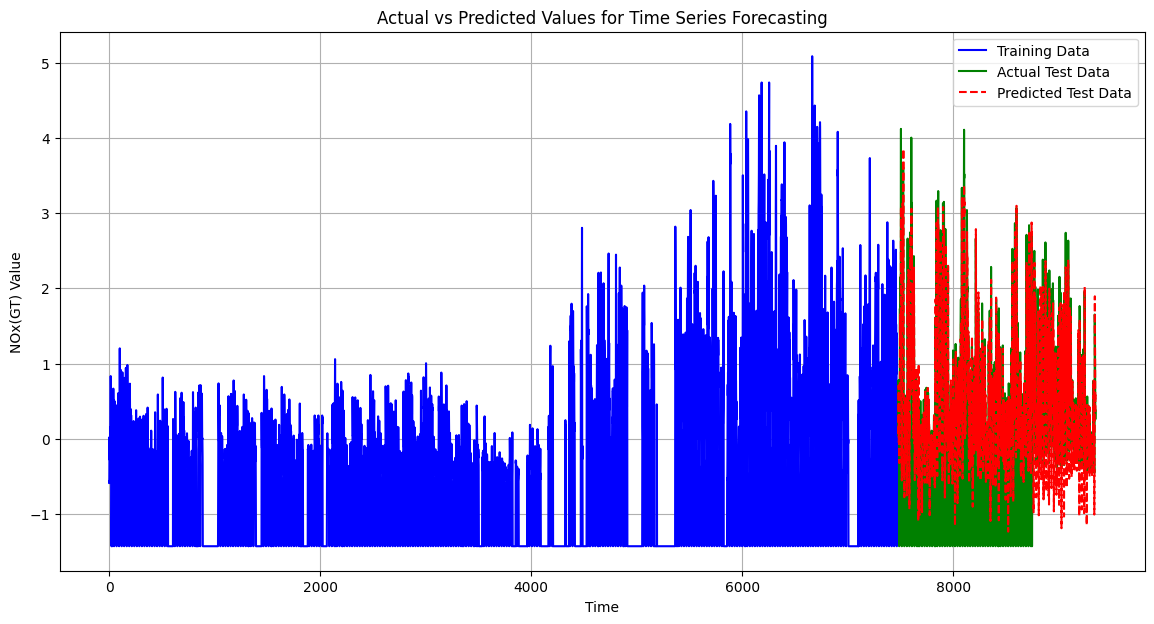

In [ ]:
# Using the feature, NOx
import matplotlib.pyplot as plt

# Create the time index for plotting
time_index_train = range(len(nox_X_train))
time_index_test = range(len(nox_X_train), len(nox_X_train) + len(nox_X_test))

# Plot the actual and predicted values
plt.figure(figsize=(14, 7))
plt.plot(time_index_train, nox_y_train, label='Training Data', color='blue')
plt.plot(time_index_test, nox_y_test, label='Actual Test Data', color='green')
plt.plot(time_index_test, nox_y_pred, label='Predicted Test Data', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('NOx(GT) Value')
plt.title('Actual vs Predicted Values for Time Series Forecasting')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

<b>Guide Question 2. </b> If you were to assess the air quality based on those 4 features, how would you say that your model is "acceptable" in terms of predicting air quality?

Both the random forest and SVM models used in this exercise showed satisfactory predictive capabilities when tested. Under the time series approach, model performance is measured by comparing the model's predictions against the actual values. When the features were scaled/normalized, the regression models used were able to achieve an MSE of below 0.2 for CO and NOx and an MSE of below 0.1 for C6H6 and NMHC.

# Classification Problem

In [1]:
# Importing all the libraries we need

# For importing the dataset.
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

# For one hot encoding.
from sklearn.preprocessing import OneHotEncoder

# For partitioning the data into training and testing sets.
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


In [2]:
# Since the column names are incomplete, we just name the columns: x1, x2, x3,...
rice = pd.read_csv("rice.csv", skiprows = 1, names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'y'])

In [3]:
rice

,x1,x2,x3,x4,x5,x6,x7,y
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo
...,...,...,...,...,...,...,...,...
3805,11441,415.858002,170.486771,85.756592,0.864280,11628,0.681012,Osmancik
3806,11625,421.390015,167.714798,89.462570,0.845850,11904,0.694279,Osmancik
3807,12437,442.498993,183.572922,86.801979,0.881144,12645,0.626739,Osmancik
3808,9882,392.296997,161.193985,78.210480,0.874406,10097,0.659064,Osmancik


In [5]:
# Define a function that checks for non-numeric values in the first seven columns of the dataframe.

def check_cols(df):

    # Check for non-numeric values
    non_numeric_mask = df.iloc[:, :7].apply(lambda x: pd.to_numeric(x, errors='coerce')).isna()

    # Check for missing values
    missing_mask = df.iloc[:, :7].isna()
    
    # Combine both masks
    problematic_mask = non_numeric_mask | missing_mask
    
    # Check if any problematic values exist
    if problematic_mask.any().any():
        return "Data has to be cleaned."
    else:
        return "The dataset appears to be clean and ready for further analysis."
    
    
check_cols(rice)

'The dataset appears to be clean and ready for further analysis.'

# Class Proportions

In [6]:
rice["y"].value_counts()

y
Osmancik    2180
Cammeo      1630
Name: count, dtype: int64

While an ideal dataset has a 50-50 split, a 60-40 split can still adequately represent both classes.

In [7]:
# One Hot Encode the y variable

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False) # sparse_output=False returns a dense array
y_encoded = encoder.fit_transform(rice[['y']])
encoded_column_names = [f"y{i+1}" for i in range(y_encoded.shape[1])]
y_df = pd.DataFrame(y_encoded, columns=encoded_column_names)
rice = pd.concat([rice.drop(columns=['y']), y_df], axis=1)

# Display the first few rows of the updated DataFrame
rice.head()

,x1,x2,x3,x4,x5,x6,x7,y1,y2
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,1.0,0.0
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,1.0,0.0
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,1.0,0.0
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,1.0,0.0
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,1.0,0.0


## Partition the Data to X and Y

In [8]:
# Split the DataFrame into df_x and df_y
df_x = rice.iloc[:, :7]  # Select the first 7 columns (x1, x2, ..., x7)
df_y = rice.iloc[:, 7:]  # Select the remaining columns (y1, y2)

# Display the first few rows of df_x and df_y to verify the split
print("df_x:")
print(df_x.head())

print("\ndf_y:")
print(df_y.head())

df_x:
      x1          x2          x3         x4        x5     x6        x7
0  15231  525.578979  229.749878  85.093788  0.928882  15617  0.572896
1  14656  494.311005  206.020065  91.730972  0.895405  15072  0.615436
2  14634  501.122009  214.106781  87.768288  0.912118  14954  0.693259
3  13176  458.342987  193.337387  87.448395  0.891861  13368  0.640669
4  14688  507.166992  211.743378  89.312454  0.906691  15262  0.646024

df_y:
    y1   y2
0  1.0  0.0
1  1.0  0.0
2  1.0  0.0
3  1.0  0.0
4  1.0  0.0


## Partition the dataset to 80% training and 20% testing.

In [26]:
classification_results = {}

# Ratio of Split
test_size = 0.2 # 20%

# Random state to achieve similar results
random_state = 12345

#random_state = random.seed(12345)

# Split the data into training and testing sets
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=test_size, random_state=random_state)

# Display the shapes of the resulting datasets to verify the split
print("df_x_train shape:", df_x_train.shape)
print("df_x_test shape:", df_x_test.shape)
print("df_y_train shape:", df_y_train.shape)
print("df_y_test shape:", df_y_test.shape)

df_x_train shape: (3048, 7)
df_x_test shape: (762, 7)
df_y_train shape: (3048, 2)
df_y_test shape: (762, 2)


In [27]:
# Convert the one-hot encoded target (df_y_train and df_y_test) back to 1D arrays
df_y_train_1d = np.argmax(df_y_train.values, axis=1)
df_y_test_1d = np.argmax(df_y_test.values, axis=1)

# Initialize the classifiers
rf_classifier = RandomForestClassifier(random_state=42)
gnb_classifier = GaussianNB()

# Train the Random Forest Classifier
rf_classifier.fit(df_x_train, df_y_train_1d)

# Train the Gaussian Naive Bayes Classifier
gnb_classifier.fit(df_x_train, df_y_train_1d)

# Predict using the trained classifiers on the test set
rf_predictions = rf_classifier.predict(df_x_test)
gnb_predictions = gnb_classifier.predict(df_x_test)

# Evaluate the classifiers using accuracy score
rf_accuracy = accuracy_score(df_y_test_1d, rf_predictions)
gnb_accuracy = accuracy_score(df_y_test_1d, gnb_predictions)

# Display the accuracy scores
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")
print(f"Gaussian Naive Bayes Accuracy: {gnb_accuracy * 100:.2f}%")

classification_results['80/20'] = [rf_accuracy, gnb_accuracy]

Random Forest Accuracy: 93.31%
Gaussian Naive Bayes Accuracy: 92.26%


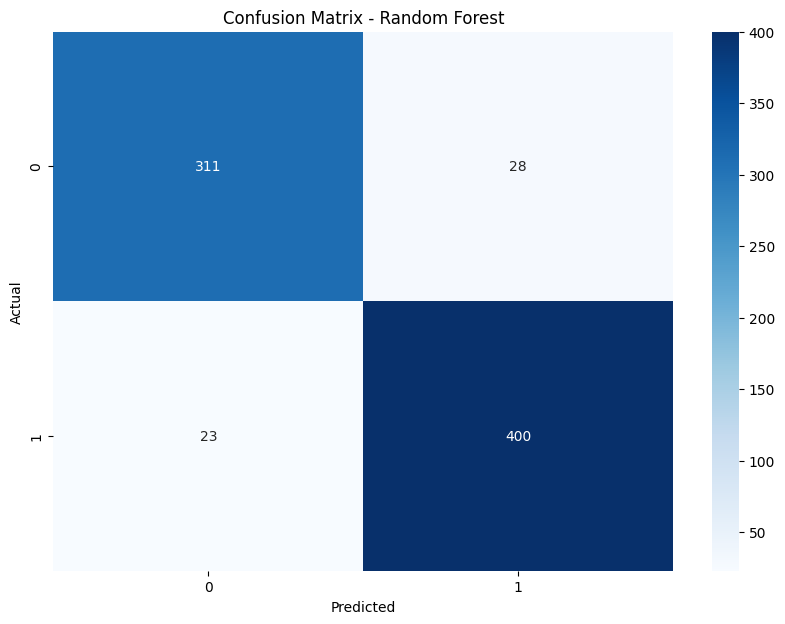

In [29]:
# Create the confusion matrix
cm = confusion_matrix(df_y_test_1d, rf_predictions)

# Create a pyplot figure
plt.figure(figsize=(10,7))

# Create the heatmap using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set the labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')

# Show the plot
plt.show()

## Partition the dataset to 70% training and 30% testing.

In [30]:
# Ratio of Split

test_size = 0.3 # 30%

# Random state to achieve similar results
random_state = 12345

#random_state = random.seed(12345)

# Split the data into training and testing sets
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=test_size, random_state=random_state)

# Display the shapes of the resulting datasets to verify the split
print("df_x_train shape:", df_x_train.shape)
print("df_x_test shape:", df_x_test.shape)
print("df_y_train shape:", df_y_train.shape)
print("df_y_test shape:", df_y_test.shape)

df_x_train shape: (2667, 7)
df_x_test shape: (1143, 7)
df_y_train shape: (2667, 2)
df_y_test shape: (1143, 2)


In [32]:
# Convert the one-hot encoded target (df_y_train and df_y_test) back to 1D arrays
df_y_train_1d = np.argmax(df_y_train.values, axis=1)
df_y_test_1d = np.argmax(df_y_test.values, axis=1)

# Initialize the classifiers
rf_classifier = RandomForestClassifier(random_state=42)
gnb_classifier = GaussianNB()

# Train the Random Forest Classifier
rf_classifier.fit(df_x_train, df_y_train_1d)

# Train the Gaussian Naive Bayes Classifier
gnb_classifier.fit(df_x_train, df_y_train_1d)

# Predict using the trained classifiers on the test set
rf_predictions = rf_classifier.predict(df_x_test)
gnb_predictions = gnb_classifier.predict(df_x_test)

# Evaluate the classifiers using accuracy score
rf_accuracy = accuracy_score(df_y_test_1d, rf_predictions)
gnb_accuracy = accuracy_score(df_y_test_1d, gnb_predictions)

# Display the accuracy scores
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")
print(f"Gaussian Naive Bayes Accuracy: {gnb_accuracy * 100:.2f}%")

classification_results['70/30'] = [rf_accuracy, gnb_accuracy]

Random Forest Accuracy: 92.65%
Gaussian Naive Bayes Accuracy: 91.16%


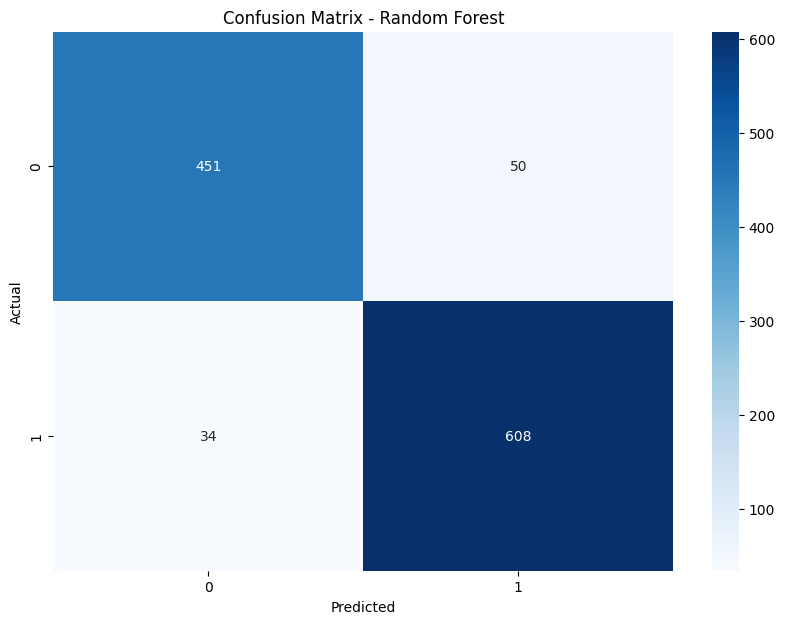

In [34]:
# Create the confusion matrix
cm = confusion_matrix(df_y_test_1d, rf_predictions)

# Create a pyplot figure
plt.figure(figsize=(10,7))

# Create the heatmap using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set the labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')

# Show the plot
plt.show()

## Partition the dataset to 60% training and 40% testing.

In [35]:
# Ratio of Split

test_size = 0.4 # 40%

# Random state to achieve similar results
random_state = 12345

#random_state = random.seed(12345)

# Split the data into training and testing sets
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=test_size, random_state=random_state)

# Display the shapes of the resulting datasets to verify the split
print("df_x_train shape:", df_x_train.shape)
print("df_x_test shape:", df_x_test.shape)
print("df_y_train shape:", df_y_train.shape)
print("df_y_test shape:", df_y_test.shape)

df_x_train shape: (2286, 7)
df_x_test shape: (1524, 7)
df_y_train shape: (2286, 2)
df_y_test shape: (1524, 2)


In [36]:
# Convert the one-hot encoded target (df_y_train and df_y_test) back to 1D arrays
df_y_train_1d = np.argmax(df_y_train.values, axis=1)
df_y_test_1d = np.argmax(df_y_test.values, axis=1)

# Initialize the classifiers
rf_classifier = RandomForestClassifier(random_state=42)
gnb_classifier = GaussianNB()

# Train the Random Forest Classifier
rf_classifier.fit(df_x_train, df_y_train_1d)

# Train the Gaussian Naive Bayes Classifier
gnb_classifier.fit(df_x_train, df_y_train_1d)

# Predict using the trained classifiers on the test set
rf_predictions = rf_classifier.predict(df_x_test)
gnb_predictions = gnb_classifier.predict(df_x_test)

# Evaluate the classifiers using accuracy score
rf_accuracy = accuracy_score(df_y_test_1d, rf_predictions)
gnb_accuracy = accuracy_score(df_y_test_1d, gnb_predictions)

# Display the accuracy scores
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")
print(f"Gaussian Naive Bayes Accuracy: {gnb_accuracy * 100:.2f}%")

classification_results['60/40'] = [rf_accuracy, gnb_accuracy]

Random Forest Accuracy: 92.52%
Gaussian Naive Bayes Accuracy: 91.14%


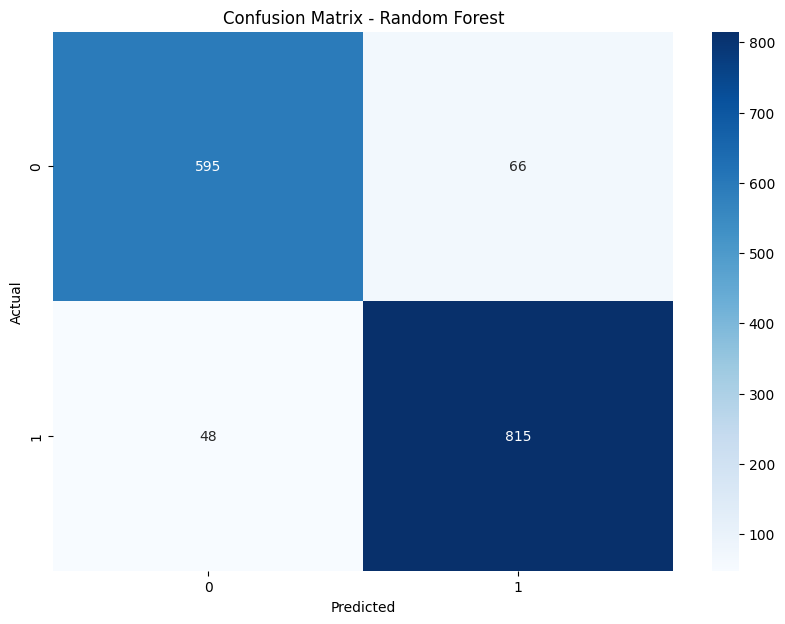

In [37]:
# Create the confusion matrix
cm = confusion_matrix(df_y_test_1d, rf_predictions)

# Create a pyplot figure
plt.figure(figsize=(10,7))

# Create the heatmap using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set the labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')

# Show the plot
plt.show()

## Partition the dataset to 50% training and 50% testing.

In [38]:
# Ratio of Split

test_size = 0.5 # 50%

# Random state to achieve similar results
random_state = 12345

#random_state = random.seed(12345)

# Split the data into training and testing sets
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=test_size, random_state=random_state)

# Display the shapes of the resulting datasets to verify the split
print("df_x_train shape:", df_x_train.shape)
print("df_x_test shape:", df_x_test.shape)
print("df_y_train shape:", df_y_train.shape)
print("df_y_test shape:", df_y_test.shape)

df_x_train shape: (1905, 7)
df_x_test shape: (1905, 7)
df_y_train shape: (1905, 2)
df_y_test shape: (1905, 2)


In [39]:
# Convert the one-hot encoded target (df_y_train and df_y_test) back to 1D arrays
df_y_train_1d = np.argmax(df_y_train.values, axis=1)
df_y_test_1d = np.argmax(df_y_test.values, axis=1)

# Initialize the classifiers
rf_classifier = RandomForestClassifier(random_state=42)
gnb_classifier = GaussianNB()

# Train the Random Forest Classifier
rf_classifier.fit(df_x_train, df_y_train_1d)

# Train the Gaussian Naive Bayes Classifier
gnb_classifier.fit(df_x_train, df_y_train_1d)

# Predict using the trained classifiers on the test set
rf_predictions = rf_classifier.predict(df_x_test)
gnb_predictions = gnb_classifier.predict(df_x_test)

# Evaluate the classifiers using accuracy score
rf_accuracy = accuracy_score(df_y_test_1d, rf_predictions)
gnb_accuracy = accuracy_score(df_y_test_1d, gnb_predictions)

# Display the accuracy scores
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")
print(f"Gaussian Naive Bayes Accuracy: {gnb_accuracy * 100:.2f}%")

classification_results['50/50'] = [rf_accuracy, gnb_accuracy]

Random Forest Accuracy: 91.97%
Gaussian Naive Bayes Accuracy: 90.76%


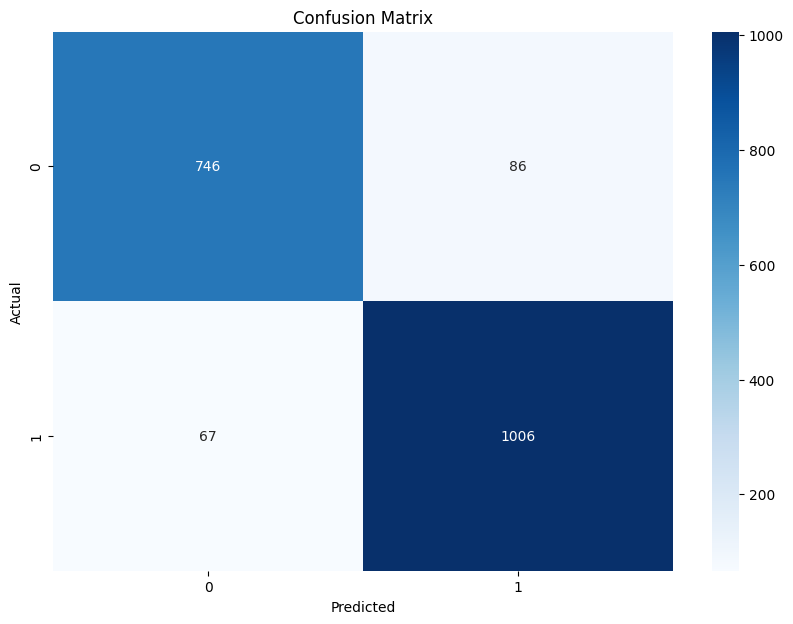

In [40]:
# Create the confusion matrix
cm = confusion_matrix(df_y_test_1d, rf_predictions)

# Create a pyplot figure
plt.figure(figsize=(10,7))

# Create the heatmap using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set the labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [45]:
classification_results

# Convert to a pandas dataframe

results = pd.DataFrame(classification_results)
results = results.T
results.columns = ["Random Forest", "Gaussian Naive Bayes"]
results

,Random Forest,Gaussian Naive Bayes
80/20,0.933071,0.922572
70/30,0.926509,0.911636
60/40,0.925197,0.911417
50/50,0.919685,0.907612


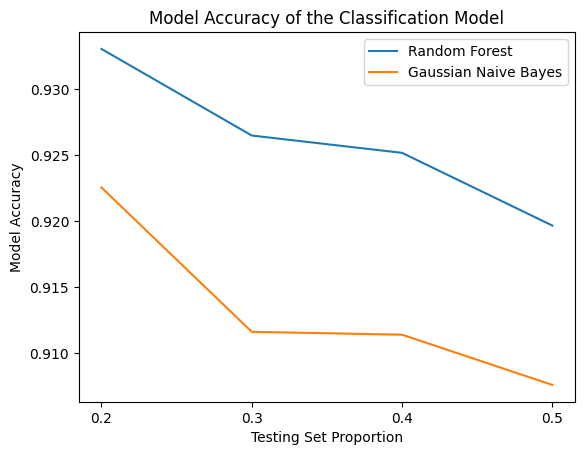

In [51]:
import matplotlib.pyplot as plt

x_vals = [0.20, 0.30, 0.40, 0.50]

plt.plot(x_vals, results["Random Forest"], label = "Random Forest")
plt.plot(x_vals, results["Gaussian Naive Bayes"], label = "Gaussian Naive Bayes")

plt.xlabel('Testing Set Proportion')
plt.ylabel('Model Accuracy')
plt.title('Model Accuracy of the Classification Model')

plt.xticks([0.2, 0.3, 0.4, 0.5])

# Add a legend
plt.legend()

# Show the plot
plt.show()

<b>Guide Question 1. </b> Is there a trend that you notice as the training size goes smaller and the testing size gets bigger? (show proof if there is)

In both of the classification models we tested on the rice dataset, we found that as the testing set proportion increased from 20% up to 50%, the accuracy of the models steadily decreased. These findings suggest that the classification models got better at classifying the testing set labels when more data was used to train the models. Moreover, these results indicate that there was no prolem of diminishing returns or overfitting when a greater proportion of the data was used to train the model.

<b>Guide Question 2.</b> If ever there is a trend, will this be a valid measure of performance of a model? Why or why not?


Yes, a similar downward trend was observed in both the Random Forest and Gaussian Naive Bayes models tested. This reinforces our observation of an inverse relationship between the proportion of the testing set and the accuracy or performance of the model.

The metric we used to evaluate the performance of the model was the model's accuracy score. It is one of the most commonly used metrics for evaluating classification models with a fairly balanced class distribution. In general, the Random Forest model was more accurate than the Gaussian Naive Bayes model at classfying the observations. Moreover, both models were able to achieve an accuracy score of above 0.9 in all of the train/test splits we tried.